# Identifying bursting events from calcium transients 
###  Marco Arieli Herrera-Valdez$^1$ & Daniel Torres-Torres$^1$ 
#### $^1$ Facultad de Ciencias, UNAM


In [68]:
from transientPreAnalysis import *
%matplotlib inline

In [69]:
# Setup path for data directory and filename
dataDir="./microcircuitsNetworks/"
fileName= "cort76dp1c.pxp"
fMinData,sampTimes=extractDebleachedFminData(dataDir+fileName)
nCells=len(fMinData)
# Find how many time series were extracted
print("Found %d time series"%nCells)

Found 330 time series


In [129]:
# Approximate the derivative of the signal
def calcTwoSideSecantSlope(t,signal):
    nPts=len(f)
    dfFwd= sc.zeros(nPts)
    dfBwd= sc.zeros(nPts)
    df= sc.zeros(nPts)
    dfFwd[1:] = (signal[1:]-signal[:-1])/(t[1:]-t[:-1])
    dfBwd[:-1] = dfFwd[1:]
    df = (dfFwd + dfBwd )/2.0
    return df

In [152]:
n=25; #n=209; #n=200 #n=110
# Count the number of sampling points in the records
f = fMinData[n]
# Smooth the data using the reverse Fourier transform with a hiCut filtering scheme
# The sampling rates are no higher than 10 Hz, so the highest frequency from the signal 
# that can be recovered from the samples is no more than 5 Hz. 
# A hiCut filter was set to 20 Hz to make sure that most transients are caught, without loosing resolution.
fSmooth=lowHighCutFreqSmoothing(x=f,lowCut=0,hiCut=30)
# Approximate the derivative of the signal 
df =calcTwoSideSecantSlope(sampTimes,fSmooth)

0.0007958935462182399
[ 1.02431672  1.02457283  1.0248522   1.02515515  1.02548189  1.02583254
  1.02620712  1.02660553  1.0270276   1.027473    1.02794134  1.02843206
  1.02894454  1.02947799  1.03003155  1.03060422  1.0311949   1.03180238
  1.03242533  1.03306235  1.03371192  1.03437245  1.03504224  1.03571955
  1.03640254  1.03708935  1.03777804  1.03846664  1.03915316  1.03983557
  1.04051187  1.04118001  1.04183801  1.04248388  1.04311568  1.04373151
  1.04432953  1.04490798  1.04546518  1.04599952  1.04650952  1.04699377
  1.04745101  1.0478801   1.04828002  1.04864989  1.04898899  1.04929672
  1.04957265  1.0368057   1.03705899  1.03733404  1.03763152  1.03795205
  1.03829614  1.0386642   1.03905654  1.03947335  1.03991472  1.04038061
  1.04087082  1.04138508  1.04192292  1.04248379  1.04306695  1.04367157
  1.04429664  1.04494104  1.0456035   1.04628262  1.04697689  1.04768466
  1.04840417  1.04913355  1.04987082  1.05061394  1.05136073  1.052109
  1.05285645  1.05360076  1.054

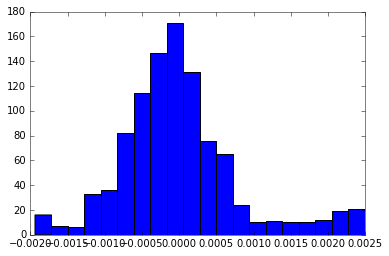

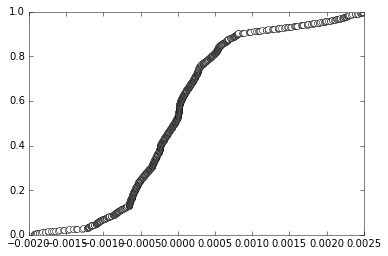

In [155]:
# Statistics from the derivative
counts = gr.hist(df, 20)
cdf, cdfInv= calcCDF(sample=df,graph=1)
alphaX=calcThresholdFromCDF(cdfInverse=cdfInv, quant=0.9)
print(alphaX)
# Find the indices in the time series that correspond to values 
burstInds = sc.where(df>alphaX)[0]
print(fSmooth[burstInds])
print(df[burstInds])

1001
1001


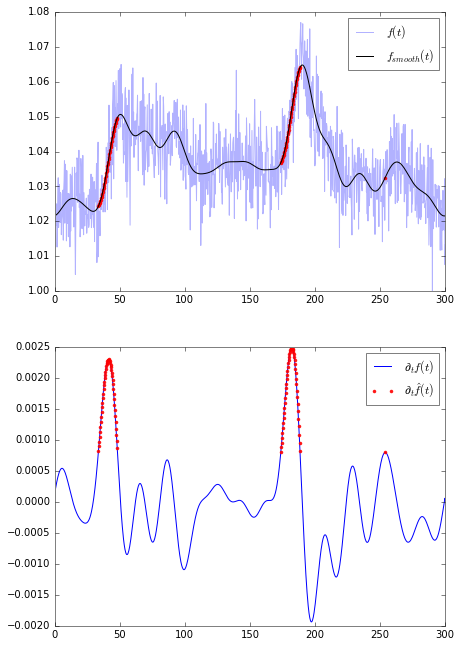

In [156]:
# Plot thresholds for event detection 
print(len(sampTimes))
print(len(f))
f0=gr.figure(figsize=(7,11)); gr.ioff()
fPlot=f0.add_subplot(2,1,1)
dfPlot=f0.add_subplot(2,1,2)
fPlot.plot(sampTimes, f, alpha=0.3, label=r"$f(t)$")
fPlot.plot(sampTimes[burstInds],fSmooth[burstInds],'r.',lw=3, alpha=0.9)
fPlot.plot(sampTimes, fSmooth, 'k', label=r"$f_{smooth}(t)$")
dfPlot.plot(sampTimes, df,label=r"$\partial_t f(t)$")
dfPlot.plot(sampTimes[burstInds],df[burstInds],'r.',lw=3, alpha=0.9, label=r"$\partial_t \hat{f}(t)$")
fPlot.legend(); dfPlot.legend()
#fPlot.set_xlim((50,150))
#dfPlot.set_xlim((50,150))
fPlot.set_xlim((0,sampTimes.max()))
dfPlot.set_xlim((0,sampTimes.max()))
gr.ion(); gr.draw()
# 

## Exploration of hi-cut filtering parameters and quantile thresholds for event detection

In [173]:
def findEvents_smooth(sampTimes, sample,quant=0.9, hiCut=20):
    fSmooth=lowHighCutFreqSmoothing(x=sample,lowCut=0,hiCut=hiCut)
    # Approximate the derivative of the signal 
    dfS=calcTwoSideSecantSlope(sampTimes,fSmooth)
    cdf, cdfInv= calcCDF(sample=dfS,graph=0)
    alphaX=calcThresholdFromCDF(cdfInv, quant)
    # Find the indices in the time series that correspond to values 
    burstInds = sc.where(dfS>alphaX)[0]
    return fSmooth, burstInds

fSmooth1,burstInds1= findEvents_smooth(sampTimes, fMinData[269],quant=0.8, hiCut=20)
print(fSmooth1)
print(len(burstInds1))
fSmooth2,burstInds2= findEvents_smooth(sampTimes,fMinData[269],quant=0.8, hiCut=30)
print(fSmooth2)
print(len(burstInds2))

[ 1.06835863  1.06864634  1.06894197 ...,  1.0675469   1.06780855
  1.06807924]
200
[ 1.06165466  1.06279318  1.06397864 ...,  1.05857287  1.05953963
  1.06056845]
200


### Varying the hi-cut filtering limit

In [172]:
n=269; #n=209; #n=200 #n=110
# Count the number of sampling points in the records
f = fMinData[n]
# 
hiCuts = sc.arange(10,61, 10)
fS=list(); dfS=list()
for cut in hiCuts:
    fSmooth=lowHighCutFreqSmoothing(x=f,lowCut=0,hiCut=cut)
    fS.append(fSmooth)
    # Approximate the derivative of the signal 
    dfS.append(calcTwoSideSecantSlope(sampTimes,fSmooth))

print(fS)

[array([ 1.06862616,  1.06868143,  1.0687398 , ...,  1.06847943,
        1.06852512,  1.06857405]), array([ 1.06835863,  1.06864634,  1.06894197, ...,  1.0675469 ,
        1.06780855,  1.06807924]), array([ 1.06165466,  1.06279318,  1.06397864, ...,  1.05857287,
        1.05953963,  1.06056845]), array([ 1.06067768,  1.06186848,  1.06311509, ...,  1.05749878,
        1.05848739,  1.05954875]), array([ 1.05826409,  1.05984614,  1.06152962, ...,  1.05426063,
        1.05545962,  1.05679771]), array([ 1.05778426,  1.05923393,  1.06080381, ...,  1.05424429,
        1.05528273,  1.05646461])]


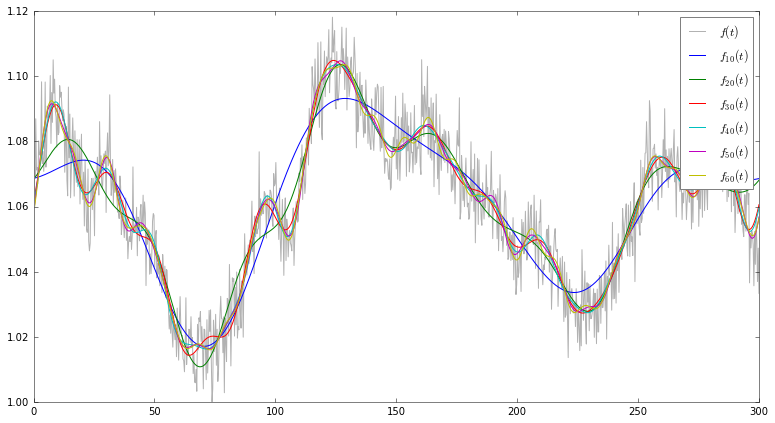

In [151]:
# Plot thresholds for event detection 
f0=gr.figure(figsize=(13,7)); gr.ioff()
fPlot=f0.add_subplot(1,1,1)
#dfPlot=f0.add_subplot(2,1,2)
fPlot.plot(sampTimes, f, 'k', alpha=0.3, label=r"$f(t)$")
for n in sc.arange(len(fS)):
    fPlot.plot(sampTimes, fS[n], label=r"$f_{%g}(t)$"%(hiCuts[n]))
    #dfPlot.plot(sampTimes, dfS[n], label=r"$\partial_t f_{%g}(t)$"%(hiCuts[n]))
fPlot.legend(); #dfPlot.legend()
#fPlot.set_xlim((50,150))
#dfPlot.set_xlim((50,150))
fPlot.set_xlim((0,sampTimes.max()))
#dfPlot.set_xlim((0,sampTimes.max()))
gr.ion(); gr.draw()
# 